프로젝트 : 네이버 영화리뷰 감성분석 도전하기

$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

Cloud shell에서 해당 파일의 심볼릭 링크를 연결한다

1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


2) 데이터로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다. 이것을 읽어서 data_loader를 만들어 보는 것으로 시작한다. data_loader 안에서는 다음을 수행해야 한다.

● 데이터의 중복 제거

● NaN 결측치 제거

● 한국어 토크나이저로 토큰화

● 불용어(Stopwords) 제거

● 사전word_to_index 구성

● 텍스트 스트링을 사전 인덱스 스트링으로 변환

● X_train, y_train, X_test, y_test, word_to_index 리턴

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()    # Mecab()을 활용하여 토크나이저 생성
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']    # 불용어

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델 구성을 위한 데이터 분석 및 가공

● 데이터셋 내 문장 길이 분포
● 적절한 최대 문장 길이 지정
● keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

● 데이터셋 내 문장 길이 분포

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


● 적절한 최대 문장 길이 지정

In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일해야 한다.

문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 된다. 이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.

● keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                          value=word_to_index["<PAD>"],
                                                          padding='pre', # 혹은 'post'
                                                          maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                         value=word_to_index["<PAD>"],
                                                         padding='pre', # 혹은 'post'
                                                         maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


한 가지 유의해야 하는 것은 padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점이다. RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 된다. 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다. 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 된다.

4) 모델 구성 및 validation set 구성

In [10]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(10000, 41)
(10000,)
(136182, 41)
(136182,)


model 훈련 전에, 훈련용 데이터셋 중 10000건을 분리하여 검증셋(validation set)으로 사용하도록 한다.

모델1: RNN

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요. 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


5) 모델 훈련 개시

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 5s 7ms/step - loss: 0.4854 - accuracy: 0.7886 - val_loss: 0.3535 - val_accuracy: 0.8480
Epoch 2/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3346 - accuracy: 0.8594 - val_loss: 0.3374 - val_accuracy: 0.8563
Epoch 3/5
266/266 [==============================] - 1s 5ms/step - loss: 0.3122 - accuracy: 0.8699 - val_loss: 0.3362 - val_accuracy: 0.8557
Epoch 4/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2981 - accuracy: 0.8767 - val_loss: 0.3434 - val_accuracy: 0.8525
Epoch 5/5
266/266 [==============================] - 1s 5ms/step - loss: 0.2856 - accuracy: 0.8833 - val_loss: 0.3373 - val_accuracy: 0.8560


In [13]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3506 - accuracy: 0.8510
[0.35062915086746216, 0.850967288017273]


6) Loss, Accuracy 그래프 시각화

model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있다. 이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 된다.

In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


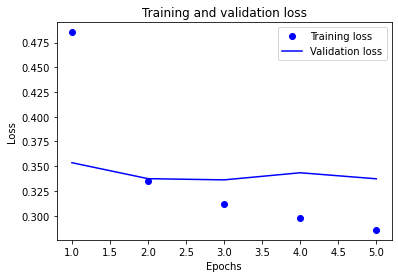

In [15]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있다. validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련이다.

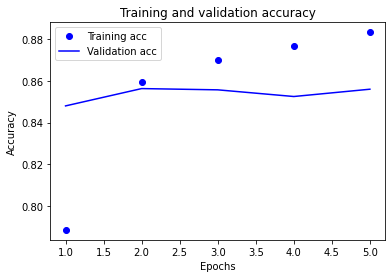

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마찬가지로 Training and validation accuracy를 그려 보아도 유사한 인사이트를 얻을 수 있습니다.

이전 스텝에서 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법으로 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법이 있다는 언급을 한 바 있다.

우리는 이미 이전 스텝에서 워드 임베딩을 사용했다. 사용했던 model의 첫 번째 레이어는 바로 Embedding 레이어였다. 이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였다. 만약 우리의 감성 분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것이다. 한번 확인해 보겠다.

$ mkdir -p ~/aiffel/sentiment_classification/data

$ pip list | grep gensim

워드 벡터 파일을 저장할 디렉터리를 먼저 생성한다. 그리고 워드 벡터를 다루는데 유용한 gensim 패키지 버전 확인을 한다.

7) 학습된 Embedding 레이어 분석

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [18]:
import os

In [19]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.0132348 ,  0.05183856,  0.13416238,  0.05761328,  0.01009145,
        0.07675304,  0.22079694, -0.0275817 ,  0.03577479, -0.15764791,
       -0.17353174, -0.09089234,  0.11312699, -0.03821357, -0.048042  ,
       -0.03644614], dtype=float32)

gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있다.

In [21]:
word_vectors.similar_by_word("배우")

[('<', 0.7824158668518066),
 ('펼쳐', 0.7780942916870117),
 ('안소니', 0.7675005197525024),
 ('염정아', 0.7556019425392151),
 ('합리', 0.7401673793792725),
 ('남겨', 0.734775960445404),
 ('줘', 0.7342950701713562),
 ('라인', 0.728154182434082),
 ('불멸', 0.71806800365448),
 ('관', 0.7149699926376343)]

워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있다. gensim을 사용하면 위와 같이 해볼 수 있다.

"배우"라는 단어와 유사한 다른 단어를 잘 찾지는 못했다. 감성 분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 어려운 것 같다. 우리가 다룬 정도의 훈련 데이터로는 워드 벡터를 정교하게 학습시키기 어렵다.

참고) 구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델이 있다. Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었다. 총 300만 개의 단어를 각각 300차원의 벡터로 표현한 것이다. Word2Vec이라는 것도 실은 Embedding Layer와 원리는 동일하다.

8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [22]:
import gensim
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector     # 무려 300dim의 워드 벡터입니다.

/tmp/ipykernel_2900/2599594261.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

적절한 ko.bin을 찾아 이용한다. 이때 gensim 버전을 3.x.x로 낮춰야 오류가 나지 않는다.

In [23]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("배우")

/tmp/ipykernel_2900/1629180810.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("배우")


[('가르치', 0.7075916528701782),
 ('익히', 0.5947338938713074),
 ('공부', 0.5693216919898987),
 ('영화배우', 0.523245096206665),
 ('연출가', 0.509418249130249),
 ('후배', 0.49829238653182983),
 ('연극배우', 0.47326865792274475),
 ('연마', 0.4723285734653473),
 ('선보이', 0.471835732460022),
 ('무용가', 0.46976548433303833)]

한국어 Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있다.

이전과 다르게 "배우"라는 단어와 유사한 단어들을 찾아내는 것을 볼 수 있다.

이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 볼 것이다.

In [24]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2900/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2900/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [25]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [26]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 4s 8ms/step - loss: 0.5265 - accuracy: 0.7269 - val_loss: 0.4365 - val_accuracy: 0.8000
Epoch 2/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3736 - accuracy: 0.8349 - val_loss: 0.3657 - val_accuracy: 0.8379
Epoch 3/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3215 - accuracy: 0.8622 - val_loss: 0.3547 - val_accuracy: 0.8450
Epoch 4/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2901 - accuracy: 0.8793 - val_loss: 0.3443 - val_accuracy: 0.8489
Epoch 5/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2648 - accuracy: 0.8921 - val_loss: 0.3494 - val_accuracy: 0.8509


In [27]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3638 - accuracy: 0.8466
[0.3637723922729492, 0.8465732336044312]


한국어 Word2Vec을 정상적으로 잘 활용하면 그렇지 않은 경우보다 5% 이상의 성능 향상이 발생한다. 적절한 모델 구성, 하이퍼파라미터를 고려하여 감정 분석 모델의 성능을 최대한으로 끌어올려 보자.

모델 2: 1-D Convolution Neural Network(1-D CNN)

텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 수도 있다.

우리는 이미지 분류기를 구현하면서 2-D CNN을 이미 사용해 본 바 있다. 하지만 이미지는 시퀀스 데이터가 아니다. 이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용된다.

그러므로 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용된다. 이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여준다.
그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있다.

In [28]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 5ms/step - loss: 0.4797 - accuracy: 0.7602 - val_loss: 0.3477 - val_accuracy: 0.8491
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3220 - accuracy: 0.8632 - val_loss: 0.3318 - val_accuracy: 0.8543
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2913 - accuracy: 0.8794 - val_loss: 0.3280 - val_accuracy: 0.8565
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2648 - accuracy: 0.8920 - val_loss: 0.3334 - val_accuracy: 0.8575
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2377 - accuracy: 0.9065 - val_loss: 0.3490 - val_accuracy: 0.8551


In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3622 - accuracy: 0.8494
[0.36222559213638306, 0.8494212627410889]


In [31]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


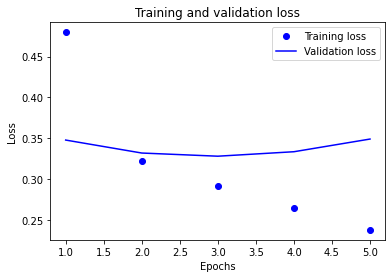

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

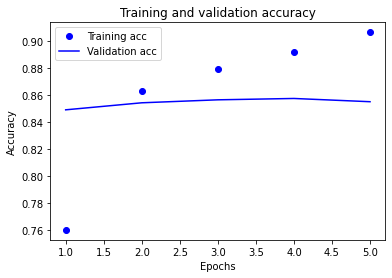

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.03387628, -0.00817413,  0.01011881, -0.02975073,  0.0163221 ,
       -0.06244872,  0.01924955, -0.03106625,  0.0809558 ,  0.00338599,
       -0.06629422, -0.01191974,  0.06917993, -0.0477321 ,  0.03540657,
        0.07599922], dtype=float32)

In [37]:
word_vectors.similar_by_word("배우")

[('표면', 0.8478031754493713),
 ('이용', 0.8453750610351562),
 ('성격', 0.8426764607429504),
 ('앵글', 0.8299316167831421),
 ('홍콩', 0.814052939414978),
 ('힘든', 0.8131386041641235),
 ('발상', 0.8115106225013733),
 ('불사신', 0.8084110021591187),
 ('멘', 0.8023529052734375),
 ('35', 0.8002607226371765)]

모델3: GlobalMaxPooling1D()

아주 간단히는 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있다. 이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있다.

In [38]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 1s 4ms/step - loss: 0.5851 - accuracy: 0.7305 - val_loss: 0.4170 - val_accuracy: 0.8267
Epoch 2/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3738 - accuracy: 0.8393 - val_loss: 0.3555 - val_accuracy: 0.8453
Epoch 3/5
266/266 [==============================] - 1s 3ms/step - loss: 0.3257 - accuracy: 0.8621 - val_loss: 0.3447 - val_accuracy: 0.8487
Epoch 4/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2996 - accuracy: 0.8744 - val_loss: 0.3444 - val_accuracy: 0.8500
Epoch 5/5
266/266 [==============================] - 1s 3ms/step - loss: 0.2806 - accuracy: 0.8833 - val_loss: 0.3481 - val_accuracy: 0.8516


In [40]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3640 - accuracy: 0.8448
[0.36400240659713745, 0.8448440432548523]


In [41]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


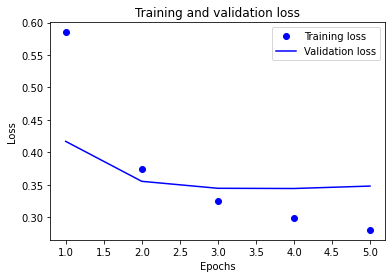

In [42]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

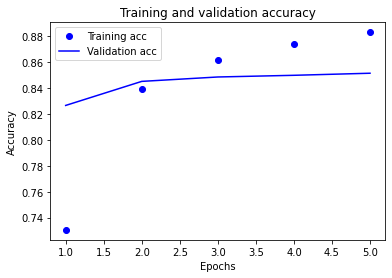

In [43]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.1191226 , -0.12300779, -0.13981497,  0.00376659, -0.11766067,
       -0.11033949, -0.11004899, -0.09206816, -0.1139866 , -0.10486068,
        0.0297949 , -0.08735888, -0.133512  , -0.14002492, -0.14376971,
       -0.10854124], dtype=float32)

In [47]:
word_vectors.similar_by_word("배우")

[('알', 0.9767473936080933),
 ('열라', 0.9689788818359375),
 ('보리', 0.9679956436157227),
 ('것', 0.9660845994949341),
 ('너무', 0.9594857096672058),
 (',', 0.9550538063049316),
 ('다', 0.954706609249115),
 ('해', 0.9533340334892273),
 ('죵', 0.9526307582855225),
 ('강소라', 0.9483922719955444)]

<모델평가>

3가지의 모델들을 구성해보았는데, 모델별로 성능차이가 거의 없었다. GlobalMaxPooling1D() 모델이 그나마 조금 낮을 뿐이었다. 또 한국어 Word2Vec을 사용했을 때, 해당 모델의 성능향상을 볼 수 없었다. 5%는 커녕 오히려 내려갔다.

EXPLORATION 6 회고

1. 이번 프로젝트에서 어려웠던 점

● 내용자체가 매우 어렵지는 않았으나, 이론 뒷부분(Word2Vec)을 이해하는데 시간이 걸렸다.

2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

● RNN 활용 시 pad_sequences의 padding 방식은 'post'와 'pre'가 있다. RNN은 입력데이터가 순차적으로 처리되기 때문에 가장 마지막 입력이 최종 state값에 가장 영향을 많이 미치게 된다. 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적이다. 따라서 'post'대신 'pre'를 사용하였다.

● 한국어 Word2Vec을 사용했을 때, 의미있는 성능 향상을 기대했는데 향상이 되지 않았다. 한국어 처리를 위한 다른 노력이 필요하다고 생각된다.

● 역시 과적합은 좋지 않다. 그래프를 이용하여 어느 부분부터 과적합이 일어났는지 확인하였고, 이후 epoch를 줄여 성능을 조금이나마 높였다.


3. 루브릭 평가지표를 맞추기 위해 시도한 것들

● 기본적인 순서를 따라 프로젝트를 진행하였고, 마지막에 한국어 Word2Vec 임베딩을 활용하여 성능 개선을 시도하였다.


4. 자기 다짐

● 자연어 처리가 마냥 어렵다고 느꼈는데, 조금은 익숙해졌다고 판단된다. 앞으로 자연어 처리와 관련한 프로젝트를 하게 되면 더 잘하길 바란다.